# Introducton to Data Analysis -  Fairness in the COMPAS dataset classification

## Team Members:
-------------------------
- Eslam Mohammed
- Mohammed Almarakby

## prologue

##### In this project, we revisit the famous COMPAS dataset by performing data exploration and analysis on the samples to investigate the bias of the produced compas scores towards certain underlying groups (namely race and gender). Moreover, we train different classifiers to the ground truth scores and compare their performance with the compas scores for different groups. We give a closer look into the definition of fairness in machine learning and investigate the scores of compas with respect to the different groups, then we utilize a method for calibrating scores of the classifiers that perturbe the labels so that it produces a more fair predictions (with respect to our definition of fairness).  At the end, we define metrics to assess the performance of the fairness method used and compute its performance.

## Dataset exploration

### Imports

In [47]:
import urllib
import urllib.request
import os,sys
import numpy as np
import pandas as pd
from functools import reduce
pd.set_option('display.max_columns',None)
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as performance
from sklearn.preprocessing import scale
from random import seed, shuffle
from IPython.display import Markdown, display

%matplotlib inline

try:
    import plotly.express as px
    import plotly.figure_factory as ff
    import plotly.io as pio
    import plotly.graph_objects as go
    pio.renderers.default = "notebook_connected"
except ImportError as e:
#     !conda install --yes --prefix {sys.prefix} -c plotly plotly-orca==1.2.1 psutil requests
    print("plotly is not installed !! please install the package to be able to render plotly visualizations")


try:
    from aif360.metrics import BinaryLabelDatasetMetric
    from aif360.metrics import ClassificationMetric
    from aif360.metrics.utils import compute_boolean_conditioning_vector
    from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

    from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                    import load_preproc_data_compas
    
except ImportError as e:
    print('please install aif360 package to proceed with the fairness section')
    


### Seting up visualization properties

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
fig=plt.figure(figsize=(10,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



<Figure size 720x432 with 0 Axes>

### UTILS

In [46]:
def hist(column_name, x):
    '''
    helper function to plot historgram for a dataframe 
    '''
    return px.histogram(column_name, x = x,
                       title = 'Histogram of ' + x,
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
def plot_roc(fpr,tpr,thresholds=None,label=None):
    '''
    plot roc curve for multiple instances.
    '''
    sns.set_style("darkgrid")
    
    colors = ['red','blue','aqua', 'darkorange', 'cornflowerblue', 'burlywood', 'lightsalmon', 'olive']

    plt.figure(figsize=(12,8))
    lw = 2
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], color=colors[i],label=label[i],
             lw=lw)
        
     
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
      
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of sensitive attributes ')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower right")
    plt.show()

# def clf_roc_curve(clf,biased_towards_data,biased_against_data,attribute):
#     '''
#     ploting ROC curves for sensitive attributes for a given classifier
#     '''

#     fpr_clf,tpr_clf,label=[],[],[]

#     if attribute == 'race':
        
#         african_american_prediction = clf.predict(biased_against_data)

#         fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(african_american_samples_label.to_numpy().ravel(),
#                                                    african_american_prediction,pos_label=1)

#         fpr_clf.append(fpr_AM)
#         tpr_clf.append(tpr_AM)
#         label.append('ROC of african american')

#         caucasian_prediction = svm_classifier.predict(caucasian_samples)
#         fpr_C,tpr_C,thresholds_C = performance.roc_curve(caucasian_samples_label.to_numpy().ravel(),
#                                                    caucasian_prediction,pos_label=1)
#         fpr_clf.append(fpr_C)
#         tpr_clf.append(tpr_C)
#         label.append('ROC of Caucasians')

#     elif attribute == 'gender':
        
#         fpr_svm,tpr_svm,label=[],[],[]


#         african_american_prediction = svm_classifier.predict(african_american_samples)

#         fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(african_american_samples_label.to_numpy().ravel(),
#                                                    african_american_prediction,pos_label=1)

#         fpr_svm.append(fpr_AM)
#         tpr_svm.append(tpr_AM)
#         label.append('ROC of african american')

#         caucasian_prediction = svm_classifier.predict(caucasian_samples)
#         fpr_C,tpr_C,thresholds_C = performance.roc_curve(caucasian_samples_label.to_numpy().ravel(),
#                                                    caucasian_prediction,pos_label=1)
#         fpr_svm.append(fpr_C)
#         tpr_svm.append(tpr_C)
#         label.append('ROC of Caucasians')

#         plot_roc(fpr_svm,tpr_svm,label=label)

        
        
#     plot_roc(fpr_svm,tpr_svm,label=label)
    


### Downlaod data file and dependency files

In [5]:
SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file %s in the current directory..." % (fname))

    if fname not in files:
        print(" %s not found! Downloading from GitHub..." % fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("%s download and saved locally.." % fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file compas-scores-two-years.csv in the current directory...
 compas-scores-two-years.csv not found! Downloading from GitHub...
compas-scores-two-years.csv download and saved locally..


### load and clean data
we followed the initial cleaning techniques described via the algorithm analysis page. 

In [6]:
dataset = pd.read_csv(COMPAS_INPUT_FILE)

dataset = dataset.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

dataset = dataset[ (dataset.days_b_screening_arrest <= 30) &
(dataset.days_b_screening_arrest >= -30) &
(dataset.is_recid != -1) & (dataset.c_charge_degree != 'O') & (dataset.score_text != 'N/A') ]

dataset.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

In [7]:
dataset.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
5,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
6,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
7,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
8,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2013-10-03,Risk 

### Basic analysis of demographics
In order to analyze the demographic(sex, race) relations we decided to answer a set of fictitious questions with plots(mainly histograms) to gain an intuition about the population of the data.  
- What are the different races present in the dataset? 

- What is the number of people grouped by age category?

- What is the number of people grouped by race?

- What is the number of Males/Females grouped by race?

- What is the number of people in every COMPAS score (decile_score)?

- What is the number of people in every COMPAS risk category (score_text)?

In [8]:
def get_basic_stats(column_name,check_values=None,
                    check_NaN=False,group_count=True,plot_hist = False):
    '''
    basic stats on a given column of the dataset
    @param column_name: column name to compute stats on
    '''
    
    result = {}
    
    if column_name not in dataset.columns:
        raise ValueError("column_name must be set to a value from the the available values")
        
    #values in the column
    column_values = np.unique(dataset[column_name].values)
    
    if check_values:
        print('-',column_name,"in dataset:")
        [print(value) for value in column_values]
#         result.append()

    if check_NaN:
        print("-NaN  presenti n the column?",dataset[column_name].isnull().any())
    
    if group_count:
        #values_count = dataset.groupby(column_name).count()
        #values_count.append([{value:(dataset[column_name] == value).sum()} for value in column_values ]) 
        values_count = dataset[column_name].value_counts()   
#         print('-values count:')
#         pprint(values_count)
        result.update(values_count=values_count)
        
    #histogram of values
    if plot_hist:
        fig = hist(dataset[column_name], column_name) 
        fig.show()        
    
    return result
    
        


In [9]:
print('hisgoram of different races in the dataset')
result = get_basic_stats("race",plot_hist=True)

hisgoram of different races in the dataset


In [10]:
print('hisgoram of different ages in the dataset')
result = get_basic_stats("age", plot_hist=True)

hisgoram of different ages in the dataset


It is quite obvious how imbalanced the dataset is. *Africane-Americans* are occupying more than half of the dataset then *Caucasians*. Also, a very high percentage of the defendants are *young-aged* (20 - 30)  

We know show the population of males and females in the given races.

In [11]:
sex_race_df = pd.crosstab(dataset.race, dataset.sex)
sex_race_df = sex_race_df.stack().reset_index().rename(columns={0:"value"})

In [12]:
race = dataset.race.unique()
males = sex_race_df.value[sex_race_df.sex == 'Male']
females = sex_race_df.value[sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

*Male* is the most dominant sex here. Next, we compare the scores in each race. 

In [13]:
decile_score_per_race = pd.crosstab(dataset.decile_score, dataset.race)
decile_score_per_race = decile_score_per_race.stack().reset_index().rename(columns = {0:'values'})

In [14]:
dec_score = dataset.decile_score.unique()
afrac_amer = decile_score_per_race.values[decile_score_per_race.race == "African-American"][:,2]
hispanic = decile_score_per_race.values[decile_score_per_race.race == "Hispanic"][:,2]
asian = decile_score_per_race.values[decile_score_per_race.race == "Asian"][:,2]
causcasian = decile_score_per_race.values[decile_score_per_race.race == "Caucasian"][:,2]
native = decile_score_per_race.values[decile_score_per_race.race == "Native American"][:,2]
other = decile_score_per_race.values[decile_score_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

From the above chart, we can see that more than **50%** of the *African-Americans* are predicted to be highly likely to commit felonies or recidivate, and consequently their scores lie in the medium to high risk ranges. 

These *low*, *medium* and *high* values are actually a sort of categories for the **decile_score** computed. That is it, a mapping of ranges in the score to each category. Will discuss it in more details in the upcoming sections.

In [15]:
score_text_per_race = pd.crosstab(dataset.score_text, dataset.race)
score_text_per_race = score_text_per_race.stack().reset_index().rename(columns = {0:'values'})

In [16]:
dec_score = dataset.score_text.unique()
afrac_amer = score_text_per_race.values[score_text_per_race.race == "African-American"][:,2]
hispanic = score_text_per_race.values[score_text_per_race.race == "Hispanic"][:,2]
asian = score_text_per_race.values[score_text_per_race.race == "Asian"][:,2]
causcasian = score_text_per_race.values[score_text_per_race.race == "Caucasian"][:,2]
native = score_text_per_race.values[score_text_per_race.race == "Native American"][:,2]
other = score_text_per_race.values[score_text_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

### decile score vs race


In [17]:
def scores_stats(category, value):
    '''
    @param category: category to perform stats on
    @param value: entry in the specefied category
    '''
    scores = dataset[dataset[category] == value]
    scores = scores[['decile_score','score_text']]
    histogram,_ = np.histogram(scores['decile_score'])
    fig = px.histogram(scores['decile_score'], 'decile_score',
                       title = 'Decile score of '+ value,
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
    fig.add_shape(dict(
        type="line",
        x0 = scores['decile_score'].mean(),
        y0 = 0,
        x1 = scores['decile_score'].mean(),
        y1 = max(histogram) + 20,
        line=dict(
            color = "LightSeaGreen",
            width = 4,
            dash = "dashdot")
    ))
    fig.show()
    print('mean decile score: %.2f'%scores['decile_score'].mean())


In [18]:
#distribution and mean of decile score for african americans

scores_stats('race','African-American')

mean decile score: 5.28


In [19]:
# distribution and mean of decile score for Caucasian

scores_stats('race','Caucasian')

mean decile score: 3.64


### decile score vs gender


In [20]:
# distribution of decile score for males

scores_stats('sex','Male')

mean decile score: 4.50


In [21]:
# distribution of decile score for Females 

scores_stats('sex','Female')

mean decile score: 4.06


### Performance analysis of COMPAS


In this sub-section, we measure COMPAS's overall performance and then look through the same for selected races and genders 

The two_year_recid field records whether or not each person was re-arrested for an offense within two years, which is what COMPAS is trying to predict.


#### number people whom were re-arrested


In [22]:
#people whom got re-arrested in two years span
print('Number of people in the dataset whom got re-arrested in the span of two years: ',
      dataset['two_year_recid'].sum())

Number of people in the dataset whom got re-arrested in the span of two years:  2809


#### Number of people that got re-arrested per demogrphics categories

In [23]:
# recedivism bs race
cau_sum = dataset[(dataset['race'] == 'Caucasian') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()
print('number of caucasian in the dataset whom got re-arrested in the span of two years and \
also predicted to recid:{0}/{1}'.format(cau_sum,dataset['race'].value_counts()['Caucasian']))


number of caucasian in the dataset whom got re-arrested in the span of two years and also predicted to recid:822/2103


In [24]:
am_sum = dataset[(dataset['race'] == 'African-American') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()
print('number of african american in the dataset whom got re-arrested in the span of two years and \
also predicted to recid:{0}/{1}'.format(am_sum,dataset['race'].value_counts()['African-American']))


number of african american in the dataset whom got re-arrested in the span of two years and also predicted to recid:1661/3175


In [25]:
#recedivism by gender
male_sum = dataset[(dataset['sex'] == 'Male') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()
print('number of males in the dataset whom got re-arrested in the span of two years and \
also predicted to recid:{0}/{1}'.format(male_sum,dataset['sex'].value_counts()['Male']))


number of males in the dataset whom got re-arrested in the span of two years and also predicted to recid:2396/4997


In [26]:
female_sum = dataset[(dataset['sex'] == 'Female') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()
print('number of females in the dataset whom got re-arrested in the span of two years and \
also predicted to recid:{0}/{1}'.format(female_sum,dataset['sex'].value_counts()['Female']))


number of females in the dataset whom got re-arrested in the span of two years and also predicted to recid:413/1175


In [27]:
two_recide_sex_race_df = pd.crosstab(dataset.race[dataset.two_year_recid == 1], dataset.sex[dataset.two_year_recid == 1])
two_recide_sex_race_df = two_recide_sex_race_df.stack().reset_index().rename(columns={0:"value"})

In [28]:
race = dataset.race.unique()
males = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Male']
females = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
], layout_title_text = "Population of Male/Female recidivism in race")
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [29]:
# Plot confusion matrix without passing the classifier
from sklearn.metrics import confusion_matrix
from itertools import cycle, product
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    print("plotting the Confusion Matrix")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    print('Precision = {}'.format(precision_macro_average(cnf_matrix)))
    print('Recall = {}'.format(recall_macro_average(cnf_matrix)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()
    
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [30]:
#mapping of low medium high to decile score
print('decile score ranges in score text')
scores = dataset[['decile_score','score_text']]
low_range = scores[scores['score_text'] == 'Low']['decile_score']
print('low:',low_range.min(),low_range.max())
medium_range = scores[scores['score_text'] == 'Medium']['decile_score']
print('medium:',medium_range.min(),medium_range.max())
High_range = scores[scores['score_text'] == 'High']['decile_score']
print('high',High_range.min(),High_range.max())

decile score ranges in score text
low: 1 4
medium: 5 7
high 8 10


To be able to compare compas scores in range [1,10], to the ground truth binary 0/1, we grouped the compas scores into two groups to transfer them into binary labels
- *recidivate* means *high* = label *1*
- *will not recidivate* means *low/medium* = label *0*

In [31]:
# we split scores to new classes, high to 1 and medium/ low to zero
new_scores = dataset.copy()
new_scores['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
new_scores['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)


#### The overall performance of the compas

In [32]:
overal_accuracy = performance.accuracy_score(new_scores['two_year_recid'],
                                             new_scores['decile_score'],normalize=True)

print('Compas overall performance against the true labels: {0:3f}%'.format(overal_accuracy *100))

Compas overall performance against the true labels: 63.399222%


Now, we compute teh performance of compas in the sensitive attributes in the dataset, namely, race and gender

#### Accuracy for african american

plotting the Confusion Matrix
CCR = 0.6100787401574803
Precision = 0.6547616628996622
Recall = 0.6211659271642475
[[1303  211]
 [1027  634]]


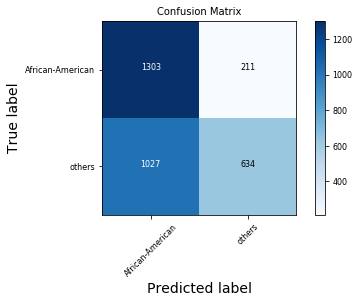

In [33]:
new_scores_african_american = new_scores[new_scores['race'] == 'African-American']
performance.accuracy_score(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'],normalize=True)

# performance.confusion_matrix(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'])
plot_conf_matrix(new_scores_african_american['two_year_recid'], new_scores_african_american['decile_score'], class_names=['African-American', 'others'] )

#### Accuracy for Caucasians

plotting the Confusion Matrix
CCR = 0.6571564431764146
Precision = 0.6876967846579525
Recall = 0.5747306221758777
[[1220   61]
 [ 660  162]]


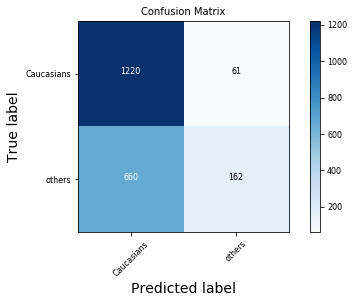

In [34]:
new_scores_Caucasian = new_scores[new_scores['race'] == 'Caucasian']
# performance.accuracy_score(new_scores_Caucasian['two_year_recid'],new_scores_Caucasian['decile_score'],normalize=True)
plot_conf_matrix(new_scores_Caucasian.two_year_recid, new_scores_Caucasian.decile_score, class_names=['Caucasians', 'others'])

#### Accuracy for females

plotting the Confusion Matrix
CCR = 0.6868085106382978
Precision = 0.6706947175082781
Recall = 0.5838671649094711
[[709  53]
 [315  98]]


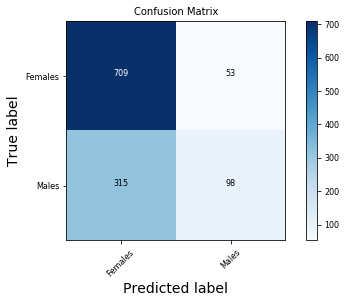

In [35]:
new_scores_female = new_scores[new_scores['sex'] == 'Female']
# performance.accuracy_score(new_scores_female['two_year_recid'],new_scores_female['decile_score'],normalize=True)
# performance.accuracy_score(new_scores_female['two_year_recid'], new_scores_female['decile_score'],normalize=True)
plot_conf_matrix(new_scores_female.two_year_recid, new_scores_female.decile_score, class_names=['Females', 'Males'])

#### accuracy for males


plotting the Confusion Matrix
CCR = 0.6215729437662597
Precision = 0.6714706491896825
Recall = 0.6093971337593926
[[2357  244]
 [1647  749]]


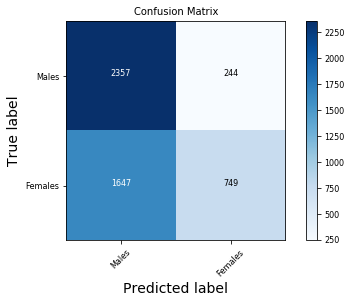

In [36]:
new_scores_male = new_scores[new_scores['sex'] == 'Male']
# performance.accuracy_score(new_scores_male['two_year_recid'],new_scores_male['decile_score'],normalize=True)
plot_conf_matrix(new_scores_male.two_year_recid, new_scores_male.decile_score, class_names=['Males', 'Females'])

5. What about false positives and false negatives?


## Part 2.2 - Standard classifiers

- In this part, We train different classifier on the "two_years_recid" ground truth, and we compare their performance, and then we plot the roc curves to investigate the bias in the classifiers towards different sensitive attributes. 

<span style="font-size:1em;">**Choice of features** </span>: Since a lot of entries in the dataset are irrelavent to the usefulness of the classifier, we perform an extra data cleaning step by droping th columns that are not useful and keeping the ones that are, we notice that we do not drop sex of race (which are the sensitive attributes) although northepoint reported not using them in their score production. Despite the fact that sensitive attribtues are problematic (with respect to multiple aspects such as law and public opinion) when used as features to classifiers, we later in the notebook see that if such attributes are very correlated with the target variable, there exist algorithmic fairness methods that allow them to be used and then using these methods we remove the disparity effect based on these attributes from the output scores. 

- Preparing for the next part, we start using IBM aif360 package, a collection of fairness algorithms and performance metrics  

- We uses the following set of features out of the 137 questions collected by northepoint, we notice that we are including the charge degree(Felony/murder), the priors count(number of crimes commited before) nad age category.

In [38]:
dataset_conditioned = load_preproc_data_compas()
print("set of features to be used out of the dataset")
pprint(dataset_conditioned.feature_names)    

set of features to be used out of the dataset
['sex',
 'race',
 'age_cat=25 to 45',
 'age_cat=Greater than 45',
 'age_cat=Less than 25',
 'priors_count=0',
 'priors_count=1 to 3',
 'priors_count=More than 3',
 'c_charge_degree=F',
 'c_charge_degree=M']


- As a normalization step, all of the data values are turned into binary values, to euqalize the effect of features with respect to the classifier.

- The race has more than one value, but since we are only interested in the sensitive attributes (bias between African American and Caucasians, we drop the other races from the dataset, this does not in turn introduce a problem, since the size of the dataset drops from 6127 entry to 5278 entry.

In [39]:
dataset_as_df,_ = dataset_conditioned.convert_to_dataframe()
print("Example samples from the dataset")
dataset_as_df.head(5)

Example samples from the dataset


,sex,race,age_cat=25 to 45,age_cat=Greater than 45,age_cat=Less than 25,priors_count=0,priors_count=1 to 3,priors_count=More than 3,c_charge_degree=F,c_charge_degree=M,two_year_recid
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
8,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
10,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
14,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Train-validate-test split

- We divide our dataset into 3 folds to train/test different classifers

In [40]:
dataset_conditioned_train, dataset_conditioned_validate_test = dataset_conditioned.split([0.7], shuffle=True)
# dataset_conditioned_validate, dataset_conditioned_test = dataset_conditioned_validate_test.split([0.5], shuffle=True)



In [41]:
print('size of traning and testing samples')
dataset_conditioned_train.convert_to_dataframe()[0].shape,dataset_conditioned_validate_test.convert_to_dataframe()[0].shape

size of traning and testing samples


((3694, 11), (1584, 11))

### Splitting females and males samples 

In [42]:
# get male samples from the dataset
male_samples = dataset_as_df[dataset_as_df['sex'] == 1.0]
male_samples_label = male_samples.filter(['two_year_recid'])
male_samples.drop(columns=['two_year_recid'],inplace=True)

# get femal samples from the dataset
female_samples = dataset_as_df[dataset_as_df['sex'] == 0.0]
female_samples_label = female_samples.filter(['two_year_recid'])
female_samples.drop(columns=['two_year_recid'],inplace=True)
print('number of female samples {0},number of male samples {1}'.format(female_samples.shape,
                                                                                      male_samples.shape))

number of female samples (4247, 10),number of male samples (1031, 10)


### splitting African american samples and caucasians samples

In [43]:

#get caucasians samples from the dataset
caucasian_samples = dataset_as_df[dataset_as_df['race'] == 1.0]
caucasian_samples_label = caucasian_samples.filter(['two_year_recid'])
caucasian_samples.drop(columns=['two_year_recid'],inplace=True)

#get african american samples from the dataset
african_american_samples = dataset_as_df[dataset_as_df['race'] == 0.0]
african_american_samples_label = african_american_samples.filter(['two_year_recid'])
african_american_samples.drop(columns=['two_year_recid'],inplace=True)
print('number of african american samples {0},number of caucasians samples {1}'.format(african_american_samples.shape,
                                                                                      caucasian_samples.shape))

number of african american samples (3175, 10),number of caucasians samples (2103, 10)


### Compas performance

Before delving into different types of classiferis, we plot the ROC curves of compas scores with respect to the senstive attributes, to inspect the true positive rate and false positive rates.

#### roc curve for black vs caucasian


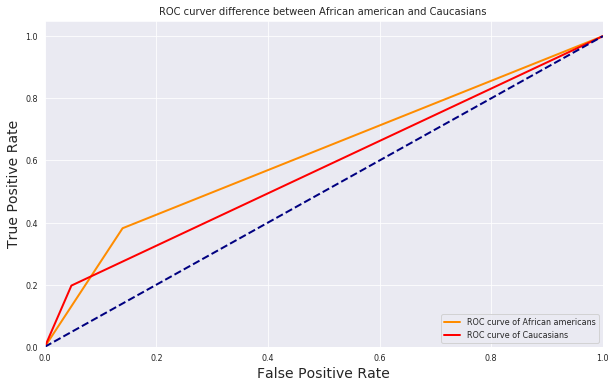

In [48]:
fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(new_scores_african_american['two_year_recid'],
                                           new_scores_african_american['decile_score'],pos_label=1)

fpr_C,tpr_C,thresholds_C = performance.roc_curve(new_scores_Caucasian['two_year_recid'],
                                           new_scores_Caucasian['decile_score'],pos_label=1)

lw = 2
sns.set_style("darkgrid")
fig=plt.figure(figsize=(10,6))
plt.plot(fpr_AM, tpr_AM, color='darkorange',label='ROC curve of African americans',
         lw=lw)
plt.plot(fpr_C, tpr_C, color='r',
         lw=lw,label='ROC curve of Caucasians')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curver difference between African american and Caucasians ')
plt.legend(loc="lower right")
plt.show()

#### roc curve for females and males

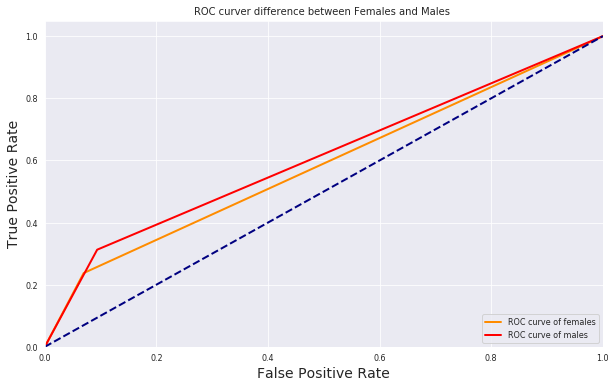

In [49]:
fpr_female,tpr_female,thresholds_female = performance.roc_curve(new_scores_female['two_year_recid'],
                                           new_scores_female['decile_score'],pos_label=1)

fpr_male,tpr_male,thresholds_male = performance.roc_curve(new_scores_male['two_year_recid'],
                                           new_scores_male['decile_score'],pos_label=1)

lw = 2
sns.set_style("darkgrid")
fig=plt.figure(figsize=(10,6))
plt.plot(fpr_female, tpr_female, color='darkorange',label='ROC curve of females',
         lw=lw)
plt.plot(fpr_male, tpr_male, color='r',
         lw=lw,label='ROC curve of males')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curver difference between Females and Males ')
plt.legend(loc="lower right")
plt.show()

### SVM


In [50]:
from sklearn.svm import SVC
svm_classifier = SVC(gamma=0.001, C=100.)
svm_classifier.fit(dataset_conditioned_train.features, dataset_conditioned_train.labels.ravel())

pred = svm_classifier.predict(dataset_conditioned_validate_test.features)

print('Accuray of the SVM on testing set {0:.2f}% '
      .format(performance.accuracy_score(dataset_conditioned_validate_test.labels, pred, normalize=True)*100))


Accuray of the SVM on testing set 64.46% 


#### Performance for race attribute

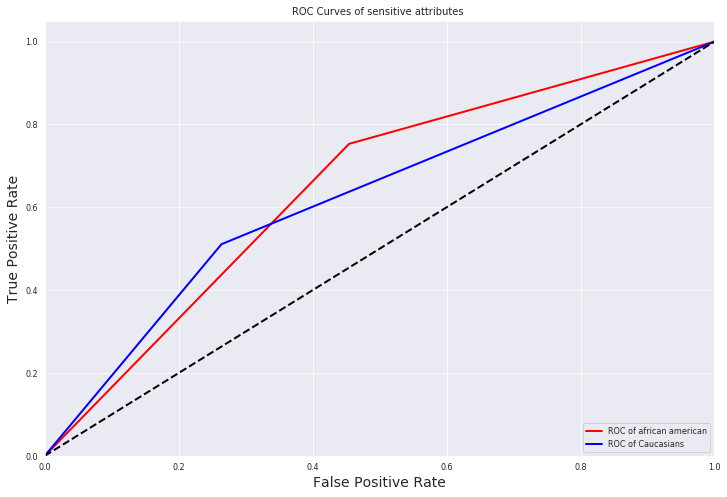

In [51]:
# ROC curve for black vs caucasian
fpr_svm_race,tpr_svm_race,label_svm_race=[],[],[]


african_american_prediction = svm_classifier.predict(african_american_samples)

fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(african_american_samples_label.to_numpy().ravel(),
                                           african_american_prediction,pos_label=1)

fpr_svm_race.append(fpr_AM)
tpr_svm_race.append(tpr_AM)
label_svm_race.append('ROC of african american')

caucasian_prediction = svm_classifier.predict(caucasian_samples)
fpr_C,tpr_C,thresholds_C = performance.roc_curve(caucasian_samples_label.to_numpy().ravel(),
                                           caucasian_prediction,pos_label=1)
fpr_svm_race.append(fpr_C)
tpr_svm_race.append(tpr_C)
label_svm_race.append('ROC of Caucasians')

plot_roc(fpr_svm_race,tpr_svm_race,label=label_svm_race)


#### performance for gender attribute

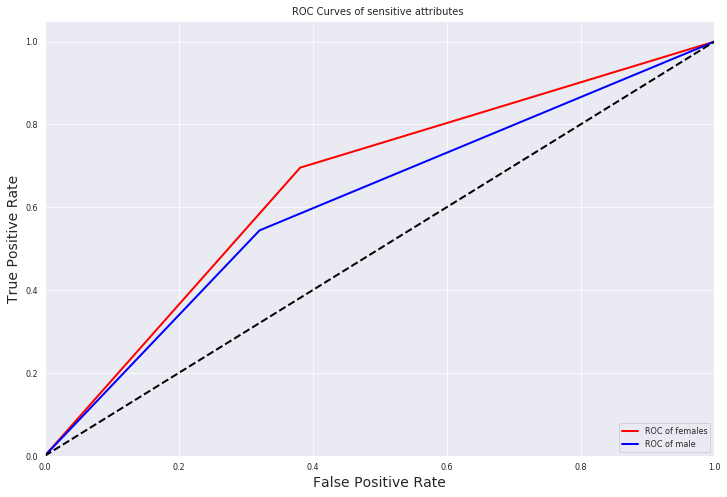

In [52]:
# ROC curve for male vs female
fpr_svm_gender,tpr_svm_gender,label_svm_gender=[],[],[]


female_prediction = svm_classifier.predict(female_samples)

fpr_female,tpr_female,thresholds_female = performance.roc_curve(female_samples_label.to_numpy().ravel(),
                                           female_prediction,pos_label=1)

fpr_svm_gender.append(fpr_female)
tpr_svm_gender.append(tpr_female)
label_svm_gender.append('ROC of females')

male_prediction = svm_classifier.predict(male_samples)
fpr_male,tpr_male,thresholds_male = performance.roc_curve(male_samples_label.to_numpy().ravel(),
                                           male_prediction,pos_label=1)
fpr_svm_gender.append(fpr_male)
tpr_svm_gender.append(tpr_male)
label_svm_gender.append('ROC of male')

plot_roc(fpr_svm_gender,tpr_svm_gender,label=label_svm_gender)


### MLP

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

hidden_layer_grid = [(x,x) for x in range(10,16,2)]

mlp_classifier = MLPClassifier()
mlp_clf_opt = GridSearchCV(mlp_classifier,param_grid={'hidden_layer_sizes':hidden_layer_grid,
                                                     'solver':['adam'],
                                                      'learning_rate_init': [0.001],
                                                      'learning_rate':['adaptive'],
                                                      'momentum':[0.9], 
                                                      'batch_size': [16]})

mlp_clf_opt.fit(dataset_conditioned_train.features, dataset_conditioned_train.labels.ravel())
pred = mlp_clf_opt.predict(dataset_conditioned_validate_test.features)

model_accuracy = performance.accuracy_score(dataset_conditioned_validate_test.labels, pred, normalize=True)*100
print(' The accuray of the MLP on training set {0:.2f}% '.format(model_accuracy))


 The accuray of the MLP on training set 64.65% 


#### performance for race attribute

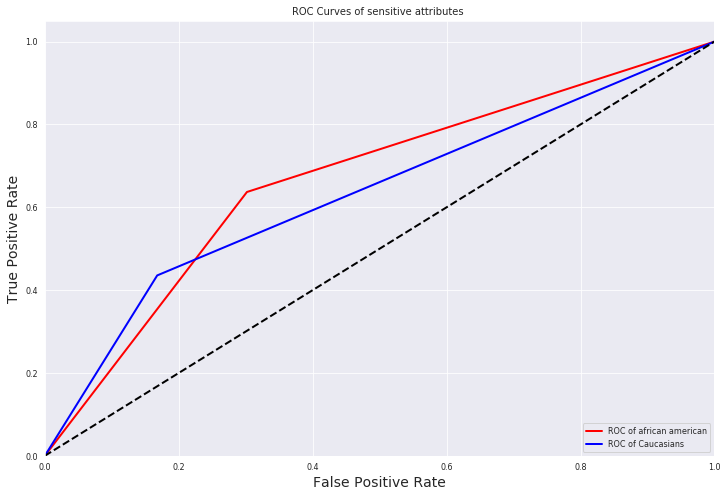

In [54]:
# ROC curve for black vs caucasian

fpr_mlp_race,tpr_mlp_race,label_mlp_race=[],[],[]


african_american_prediction = mlp_clf_opt.predict(african_american_samples)

fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(african_american_samples_label.to_numpy().ravel(),
                                           african_american_prediction,pos_label=1)

fpr_mlp_race.append(fpr_AM)
tpr_mlp_race.append(tpr_AM)
label_mlp_race.append('ROC of african american')

caucasian_prediction = mlp_clf_opt.predict(caucasian_samples)
fpr_C,tpr_C,thresholds_C = performance.roc_curve(caucasian_samples_label.to_numpy().ravel(),
                                           caucasian_prediction,pos_label=1)
fpr_mlp_race.append(fpr_C)
tpr_mlp_race.append(tpr_C)
label_mlp_race.append('ROC of Caucasians')

plot_roc(fpr_mlp_race,tpr_mlp_race,label=label_mlp_race)


#### performance for gender attribute

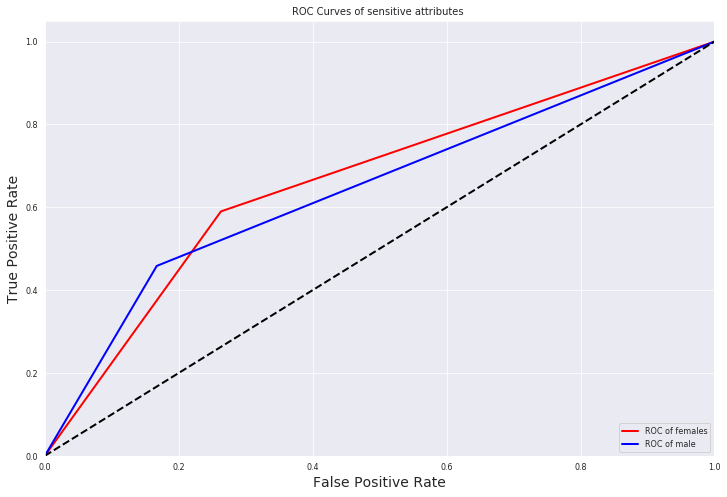

In [55]:
# ROC curve for male vs female
fpr_mlp_gender,tpr_mlp_gender,label_mlp_gender=[],[],[]


female_prediction = mlp_clf_opt.predict(female_samples)

fpr_female,tpr_female,thresholds_female = performance.roc_curve(female_samples_label.to_numpy().ravel(),
                                           female_prediction,pos_label=1)

fpr_mlp_gender.append(fpr_female)
tpr_mlp_gender.append(tpr_female)
label_mlp_gender.append('ROC of females')

male_prediction = mlp_clf_opt.predict(male_samples)
fpr_male,tpr_male,thresholds_male = performance.roc_curve(male_samples_label.to_numpy().ravel(),
                                           male_prediction,pos_label=1)
fpr_mlp_gender.append(fpr_male)
tpr_mlp_gender.append(tpr_male)
label_mlp_gender.append('ROC of male')

plot_roc(fpr_mlp_gender,tpr_mlp_gender,label=label_mlp_gender)


### Decision trees

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_classifier = DecisionTreeClassifier()

tree_clf_opt = GridSearchCV(tree_classifier,param_grid={'max_depth':[4,6,8,10,12]})
tree_clf_opt.fit(dataset_conditioned_train.features, dataset_conditioned_train.labels.ravel())

pred = tree_clf_opt.predict(dataset_conditioned_validate_test.features)

print('Accuray of the Decision tree on testing set {0:.2f}% '
      .format(performance.accuracy_score(dataset_conditioned_validate_test.labels, pred, normalize=True)*100))


Accuray of the Decision tree on testing set 64.52% 


#### for race attribute

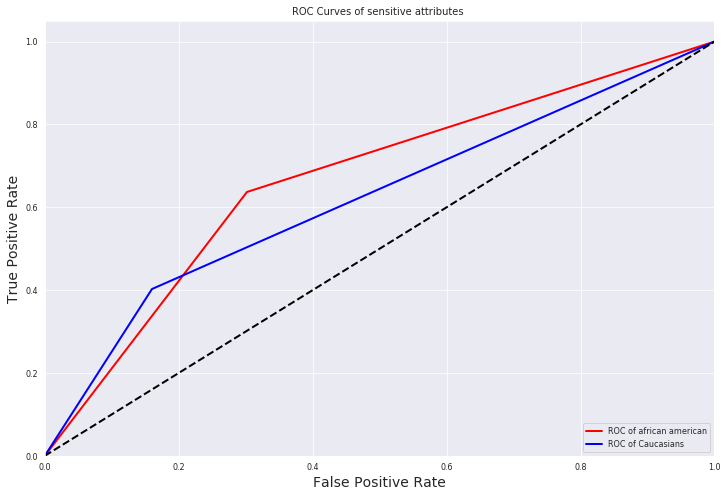

In [57]:
# ROC curve for black vs caucasian

fpr_Dec_tree_race,tpr_Dec_tree_race,label_Dec_tree_race=[],[],[]


african_american_prediction = tree_clf_opt.predict(african_american_samples)

fpr_AM,tpr_AM,thresholds_AM = performance.roc_curve(african_american_samples_label.to_numpy().ravel(),
                                           african_american_prediction,pos_label=1)

fpr_Dec_tree_race.append(fpr_AM)
tpr_Dec_tree_race.append(tpr_AM)
label_Dec_tree_race.append('ROC of african american')

caucasian_prediction = tree_clf_opt.predict(caucasian_samples)
fpr_C,tpr_C,thresholds_C = performance.roc_curve(caucasian_samples_label.to_numpy().ravel(),
                                           caucasian_prediction,pos_label=1)
fpr_Dec_tree_race.append(fpr_C)
tpr_Dec_tree_race.append(tpr_C)
label_Dec_tree_race.append('ROC of Caucasians')

plot_roc(fpr_Dec_tree_race,tpr_Dec_tree_race,label=label_Dec_tree_race)


#### performance for gender attribute

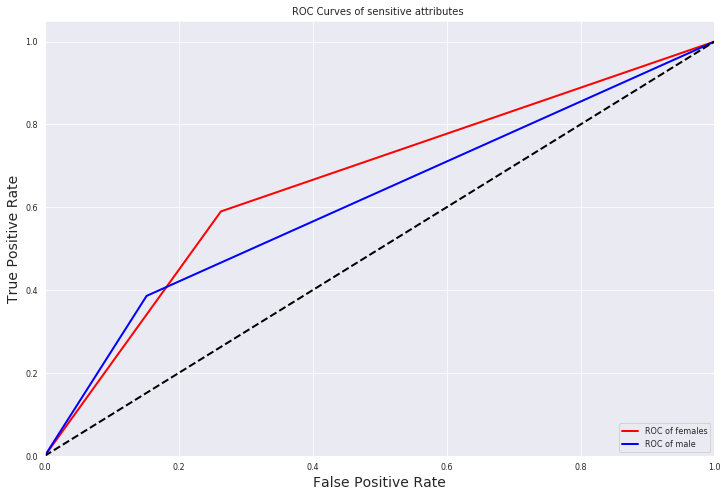

In [58]:
# ROC curve for male vs female
fpr_Dec_tree_gender,tpr_Dec_tree_gender,label_Dec_tree_gender=[],[],[]


female_prediction = tree_clf_opt.predict(female_samples)

fpr_female,tpr_female,thresholds_female = performance.roc_curve(female_samples_label.to_numpy().ravel(),
                                           female_prediction,pos_label=1)

fpr_Dec_tree_gender.append(fpr_female)
tpr_Dec_tree_gender.append(tpr_female)
label_Dec_tree_gender.append('ROC of females')

male_prediction = tree_clf_opt.predict(male_samples)
fpr_male,tpr_male,thresholds_male = performance.roc_curve(male_samples_label.to_numpy().ravel(),
                                           male_prediction,pos_label=1)
fpr_Dec_tree_gender.append(fpr_male)
tpr_Dec_tree_gender.append(tpr_male)
label_Dec_tree_gender.append('ROC of male')

plot_roc(fpr_Dec_tree_gender,tpr_Dec_tree_gender,label=label_Dec_tree_gender)


### Comments

- After training diffrent classifiers on the selected set of features, we can see that the performance (in terms of accuracy) is almost around the compas score performance **"~65-70 %"**. The best performing classifier is a multi-layer perceptron, this suggests that the mlp is able to find a set of weights for the features such that every one contributes to the score abse on its releavnt importance towards the final output. Nevertheless, the difference in accuracy between all the classifiers is not large, and it is slightly above the compas is_recid score accuracy, which might hint that the set of features that are used by northepoint might not be very representitive/very effecient towards (even though the questions collected make sense with respect to the subject) the objective of classifying whether a person will re-commit a crime or not in two years.

- We plotted the ROC curves of every classifier in the two senstive attributes "namely, race and sex", and we found out that despite the fact that the number of samples of African Americans is larger than that of Caucasians, the False postive rate (fpr) of African Americans is by far greater than that of Caucasians, this suggests that the probabilty that an African American person to be **falsly predicted** to recid is greater than that of the caucasians, while hints that the classiffer is not fair with respect to demographic parity. In the final part of the notebook, we emphasis on the correction of tpr and fpr to obtain a fair classifier.


### definition of fairness 

- **Fairness** can be defined (in an algorithmic context) as the ability to make decisions that are not skewed towards a particular cluster or congregate that exhibits similar characterstics (in our context, congregates of race and gender). For a machine learning classifier to be fair, it has to show parity in the decision it takes. Parity means that in a given dataset, if there exist underlying clusters that exhibit a similiar characteristic in the dataset (for e.g. race), even if they are not reported or used a a feature, the probablity of postiviely/negatively predicting from these clusters must be equivalent, in our context,the classifier has to show equal probability that a person will be classified to recid despite the race or gender of such person. 

- A naiive approach is that we ignore sensitive attributes (e.g. race) while traning a classifier, thinking that the classifier will be fair if these sensitivie attributes are not. But the fact that these attributes leak through the other dataset due to the existence of redundant encoding. This means that some of the features used might be slightly correlated with these sensitive attributes, even though the correlation might not be strong, if there exist large numbre of feature with small correlations, these features can build classifier that achieves high acuracy in predicting the sensitive attribute and therefore when using these set of features,the classifer can show bias towards a certain group. Another example why we can not ignore sensitive attributes is that in some fields (for e.g. medication), some attributes like race and gender is crucial in the decision to be made, hence ignoring these attributes is not the solution. 




**Fairness criteria** can be formally defined using the following notions: <br/>
**1. Independence** (demographic parity): Independence is defined as the requirement that the classifier scores to be statistically independent of the sensitive attribute. In other terms, considereing the groups of race African American and Caucasians, to have a fair classifier in terms of independence criteria, the probability that an african american will re-commit crime must be the same as that of a Caucasian, simplified in the following condition:
$P(Y=1 | A= African\;American) = P(Y=1| A= Caucasian)$ <br/>
Because the constraint in the equation can be very strict, we can relax this constraint introducing a ration instead of equality
$\frac{P(Y=1 | A= African\;American)}{ P(Y=1| A= Caucasian)} \geq 1- \epsilon$ 

A large pitfall with demographic parity is that in some cases to achieve it, it reflects back to unfairness. In our context, consider that our end goal is to predict whether a person will re-commit a crime or not, to ensure demographic parity, we will have to precisely classify whether a person will recid or not in one demographic, while randomly classify in the other demograhpics just to maintain the ratio between different demographics, in other words we will increase the tpr and decrease the fpr from one demographic just to maintain the ration, hence routing back to fairness again.

**2. Separation** (Equalized odds): we say a classifier Y satisfies separation (Equalized odd/ equal oppurtinity) if Y and the sensitive attributes A are independent conditional on the target. In Layman terms, we allow the scores to depends on the sensitive attribute, but only through the ground truth, and therefore we encourage the use of variables that directly relates to the target and not the sensitive variables.

To have a fair classifer in terms of separation, that classifiier Y should satisfy the following cirterias:

$P(Y = 1 | Y = 1, A= African\;American) = P(Y = 1 | Y = 1, A= Caucasian)$ <br/>
$P(Y = 1 | Y = 0, A= African\;American) = P(Y = 1 | Y = 0, A= Caucasian)$ <br/>

These two equations represent the true positive rate and false positive rates respectively. So essentially to achieve separation, the classifier should guarantee and equal opportunity for all the sentive groups (in our cases race and gender), whether to correctly get classify not to recid (True negative) or not to falsely classified to recid (false positive). A variant of separation is equal oppurtunity, which is to only focus on the true positive rate constraint, this is benificial in the applications like hiring where inly the rate of success (getting hired) is important in different groups of applicants.

In the fairness section we focus on correcting our clasifier (mlp since it is the highest accuracy acheving) separation to acheive a better equal odds score.


there exist multiple other criterias (e.g. sufficiency) but we focus mainly on independence and separation.

### Comparision between compas and trained classifer

- Since we will be working with separation in the next section, we compare between compas and our trained classifiers in terms of the true positive rates (tpr) and false positive rates (fpr). As shown in the ROC curves produced above, for the race atribute there is a clear bias towards having a larger fpr in african american samples, which translates to falsely predicting african americans to recid more than that for caucasians. At the same time having a higher tpr in african americans means that the classifier "whether compas or the trained classifiers" still has an ability to correctly predict recedivism, but this can be justified that the size of samples of african americans in the dataset is almost one and a half the size of caucasians, also the overall accuracy is very low "~ 63%", suggesting that the high fpr in african american is not justified by the large number of samples, rather than a bias towards falsely predicting this gender. For the gender group, The roc curve also exhibits a high fpr for the female group, which can suggest the same reason as the above that classifiers show a bias towards predicting femals to recid whether it is true or false.

## Fair classifiers

In this section, we utilize the concept of fairness in our classifiers, we first discuss the different methods to obtain a classifier that is fair in terms of a fainress criteria, and then we build a fair classifier to correct the scores of one of the tested classifiers in the last section and compute multiple fairness metrics 

### Different methods to obtain a fair classifier "add compas context" 

1. pre-proccesing
In this method, we want to adjust the feature space to be uncorrelated with the sensitive attribute, by learning a new representation of the feature space such that the information that shows correlation with the sensitive attributes are removed as much as possbile, then the classifier can use the newly represneted data and produce results that shows individual fairess to sensitive attributes.
2. in-procesing
At training time, we try to construct an optimization that yields a fair classifier, this method is considered to be the best in terms of achieving the best utility (utlity is the general objective of learning system, in our case to predict whether a person will recid or not)

3. post-processing: 
In this method, we try to modify the output of an already trained classifier such that it will satisfy  a certain fairness criteria, un-correlating the scores with the sensitive attribute. This method is in generally plausible because it allows us to deal with classifiers as a black box without going into the inner details, which becomes very handy if the traning  pipeline is very complex. of training and optimization 



#### Method 1: Calibrated Equalized odds "postprocessing" 

- To build a fair classifer, we will use the method Equalized odds (Hardt et al.,2016), it is considered as a post-procesing method since it works by trying to solve a linear program to find probabilities with which to change output labels to optimize equalized odds, i.e to remove disparity between different groups (African Americans and Caucasians, Males and Females). It is considered as a good method (in terms of utility usefulness and interpretability. 

- To Test with equalized odds, we use IBM AI Fairness 360 package, it's the equivalent of scikit-learn for fairness methods and metrics implementation. The package has an implementation for equalized odds post processing method as well as multiple fairness metrics.

In [59]:
#marking sensitive attributes in the dataset
biased_towards_gender = [{'sex': 1}]
biased_against_gender = [{'sex': 0}]

biased_towards_race = [{'race': 1}]
biased_against_race = [{'race': 0}]    

# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fpr" # "fnr", "fpr", "weighted"

#random seed for calibrated equal odds prediction reproduction
randseed = 12345679 

In [60]:
Y_training_set= mlp_clf_opt.predict(dataset_conditioned_train.features)
Y_validation_set = mlp_clf_opt.predict(dataset_conditioned_validate_test.features)

In [61]:
#preparing the training set new labels to pass it to equalized odds
predicted_labels_training = np.zeros_like(dataset_conditioned_train.labels)
predicted_labels_training[Y_training_set > 0.0] = 1.0
predicted_labels_training[~(Y_training_set > 0.0)] = 0.0
dataset_conditioned_training_prediction = dataset_conditioned_train.copy(deepcopy=True)

dataset_conditioned_training_prediction.labels = predicted_labels_training


#preparing the validation set new labels to pass it to equalized odds
predicted_labels = np.zeros_like(dataset_conditioned_validate_test.labels)
predicted_labels[Y_validation_set > 0.0] = 1.0
predicted_labels[~(Y_validation_set > 0.0)] = 0.0
dataset_conditioned_validate_prediction = dataset_conditioned_validate_test.copy(deepcopy=True)

dataset_conditioned_validate_prediction.labels = predicted_labels

In [62]:
# Learn parameters to equalize odds and apply to create a new dataset
equalized_odds_correction = CalibratedEqOddsPostprocessing(privileged_groups = biased_towards_race,
                                     unprivileged_groups = biased_against_race,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)

equalized_odds_correction = equalized_odds_correction.fit(dataset_conditioned_validate_test,
                                                          dataset_conditioned_validate_prediction)

In [63]:
training_prediction_corrected = equalized_odds_correction.predict(dataset_conditioned_training_prediction)
validate_prediction_corrected = equalized_odds_correction.predict(dataset_conditioned_validate_prediction)

### fairness metrics

To assess the impact of fairness methods on classifier, there exist a set of fairness metrics that assess the effect the methods on the scores produced by the classifiers. Since the concentration of the method we chose (namely, calibrated equalized odds) is on true postive rate (tpr) and false positive rate (fpr), we choose the set of metrics that are related to both rates.

In [64]:
#before correction
classification_metrics_training_set_before = ClassificationMetric(dataset_conditioned_train,
                                                                 dataset_conditioned_training_prediction,
                                                                 unprivileged_groups=biased_against_race,
                                                                 privileged_groups=biased_towards_race)
                 
classification_metrics_validation_set_before = ClassificationMetric(dataset_conditioned_validate_test,
                                                                 dataset_conditioned_validate_prediction,
                                                                 unprivileged_groups=biased_against_race,
                                                                 privileged_groups=biased_towards_race)


In [65]:
classification_metrics_training_set_after = ClassificationMetric(dataset_conditioned_training_prediction,
                                                                 training_prediction_corrected,
                                                                 unprivileged_groups=biased_against_race,
                                                                 privileged_groups=biased_towards_race)
                 
classification_metrics_validation_set_after = ClassificationMetric(dataset_conditioned_validate_prediction,
                                                                 validate_prediction_corrected,
                                                                 unprivileged_groups=biased_against_race,
                                                                 privileged_groups=biased_towards_race)


#### Generalized false positive rate (GFPR)

This metric is one of the important metrics with respect to our method, it measures the difference between the false positive rate in the sensitive attributes, the smaller the difference value means the calibration algorithm is able to equalize between th samples of very attribute in terms of the fpr. The acceptable range is between -0.1 and 0.1.

In [66]:
gfpr_train_after = classification_metrics_training_set_after.generalized_false_positive_rate
gfpr_valid_after = classification_metrics_validation_set_after.generalized_false_positive_rate

print('GFPR for the training set after labels correction {0:.4f}'.format(
    classification_metrics_training_set_after.difference(gfpr_train_after)))
print('GFPR for the validation set after labels correction {0:.4f}'.format(
    classification_metrics_training_set_after.difference(gfpr_valid_after)))

GFPR for the training set after labels correction -0.0676
GFPR for the validation set after labels correction -0.0818


In the GFPR value above, we can see that the calibration algorithm is able to decrease the difference between the fpr in every group, which means that the underlying gap in falsely predicting biased against group is decreasing, or the fpr of baised towards group is increasing, to match the intersection point between the two ROC curves annd equalize the bias between groups.

#### **statistical parity difference**:

This represents the difference between the probabilities of a person to be predicted to recid given his/her race. This intutively represents the equality between the probability of predicting african american/female to re-commit a crime and that of caucasians/males.

$P(Y=1|A=unprivileged) - P(Y=1|A=privileged)$

In [67]:
#before correction
spd_train_before = classification_metrics_training_set_before.statistical_parity_difference()
spd_valid_before = classification_metrics_validation_set_before.statistical_parity_difference()

print('statistical parity difference for the training set before labels correction {0:.4f}'.format(spd_train_before))
print('statistical parity difference for the validation set after labels correction {0:.4f}'.format(spd_valid_before))

statistical parity difference for the training set before labels correction -0.2248
statistical parity difference for the validation set after labels correction -0.1576


In [68]:
#after correction

spd_train_after = classification_metrics_training_set_after.statistical_parity_difference()
spd_valid_after = classification_metrics_validation_set_after.statistical_parity_difference()

print('statistical parity difference for the training set after labels correction {0:.4f}'.format(spd_train_after))
print('statistical parity difference for the validation set after labels correction {0:.4f}'.format(spd_valid_after))

statistical parity difference for the training set after labels correction -0.1503
statistical parity difference for the validation set after labels correction -0.0902


As we can see, the statistical parity decreased after calibrating the labels, we see a decrease in the difference between the probabilities of an african american to be predicted to recid and that of caucasians. This decrease mainly shows that the either tpr of african americans is increased, or the tpr of caucasians is decreased, which is evident that the calibration is trying to equalized between both groups

#### **Equal opportunity difference**:

The difference between true positive rates between different sensitive groups.

$ TPR_{A = \text{unprivileged}} - TPR_{A = \text{privileged}}$


In [69]:

tpr_train_before = classification_metrics_training_set_before.equal_opportunity_difference()
tpr_tvalidate_before = classification_metrics_validation_set_before.equal_opportunity_difference()

print('statistical parity difference for the training set after labels correction {0:.4f}'.format(tpr_train_before))
print('statistical parity difference for the validation set after labels correction {0:.4f}'.format(tpr_tvalidate_before))

statistical parity difference for the training set after labels correction -0.1505
statistical parity difference for the validation set after labels correction -0.0925


In [70]:

tpr_train_after = classification_metrics_training_set_after.statistical_parity_difference()
tpr_validate_after = classification_metrics_validation_set_after.statistical_parity_difference()

print('statistical parity difference for the training set after labels correction {0:.4f}'.format(tpr_train_after))
print('statistical parity difference for the validation set after labels correction {0:.4f}'.format(tpr_validate_after))

statistical parity difference for the training set after labels correction -0.1503
statistical parity difference for the validation set after labels correction -0.0902


##### Comments

1. In order to acheive a calibrated fair classifier, the equalized odds method tries to find the intersection point between the roc curves of both sensitive groups (for e.g. african american adn caucasians), after that it tries to find the probability with with it will perturb the labels of a given sample such that the resultant fpr and tpr of both groups is almost identical, in our experiment we showed that the difference between fpr is minimzed as much as possible $-0.0818$, and the same for the difference between the tpr $-0.0902$, which acheives the objective of eliminating the bias.
2. We note that in the process of eliminating the bias from the classifier scores, we might **increase the the fpr and increase the fpr**, which in turn **decreases overall accuracy** of the classifier at the expense of eliminating the bias

## Conclusion

In this notebook, We explored the concept of algorithmic fairness in machine learning, in terms of how would a dataset show a bias towards a certain underlying group, despite the fact that this group is not directly introduced to the algorithm as a feature, we invistegated the Compas dataset, to find out that there is a bias towards some demographics (namely, race and gender). After that we analyzed the performance of the provided compas scores to find out that the accuracy is around 63%, which is not very high accuracy with respect to the criticality of the situation it is used in. Furthermore, we trained multiple classifiers on the same dataset to investigate how would an off-the-shelf classifiers work, to find out that they produce lighlty larger accruacy $\leq5\%$ accuracy, however they showed the same underlying bias. After that we discussed the definiton of fairness in terms in our context, and then discussed the methods of achieving fairness. In order to fix this bias, we utilized the post-processing method calibrated equalized odds, concerning  mainly with the true positive rates and false positive rates of the classifiers. we calibrated the labels of predictions and compare the results using multiple fairness metrics, showing a decrease in the overall bias.

## References

1. Hardt, Moritz, Eric Price, and Nati Srebro. "Equality of opportunity in supervised learning." Advances in neural information processing systems. 2016.

2. Solon Barocas and Moritz Hardt and Arvind Narayanan, Fairness and Machine Learning.2019


________________________________